In [1]:
import numpy as np #for linear algebra and scientific computing
import pandas as pd #data analysis and manipulation

/kaggle/input/used-cars-price-prediction/test-data.csv
/kaggle/input/used-cars-price-prediction/train-data.csv


In [2]:
#data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split #split into training and testing data
from sklearn.metrics import mean_squared_error #RMSE for evaluation
from sklearn.model_selection import GridSearchCV #for exhaustive grid search(hyperparameter tuning)

#encoders for categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import category_encoders as ce

In [4]:
cars_Train = pd.read_csv("train-data.csv", index_col=0)
cars_Test = pd.read_csv("test-data.csv", index_col=0)

In [5]:
cars = cars_Train.copy()

### Let's explore the data

In [6]:
cars.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [7]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 658.3+ KB


In [8]:
cars.describe()

,Year,Kilometers_Driven,Seats,Price
count,6019.000000,6.019000e+03,5977.000000,6019.000000
mean,2013.358199,5.873838e+04,5.278735,9.479468
std,3.269742,9.126884e+04,0.808840,11.187917
min,1998.000000,1.710000e+02,0.000000,0.440000
25%,2011.000000,3.400000e+04,5.000000,3.500000
50%,2014.000000,5.300000e+04,5.000000,5.640000
75%,2016.000000,7.300000e+04,5.000000,9.950000
max,2019.000000,6.500000e+06,10.000000,160.000000


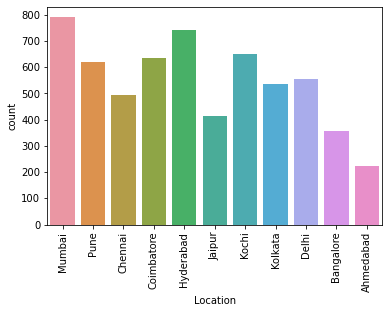

In [9]:
#1   Location
plt.xticks(rotation = 90)
sns.countplot(cars.Location)

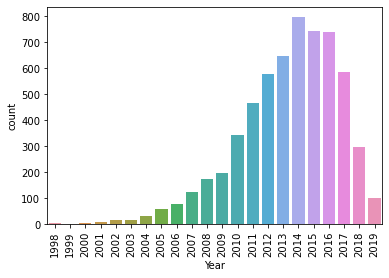

In [10]:
#2   Year
plt.xticks(rotation = 90)
sns.countplot(cars.Year)

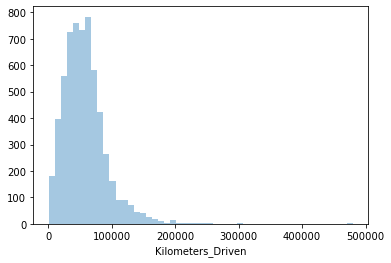

In [11]:
#3   Kilometers_Driven
sns.distplot(cars[cars.Kilometers_Driven<500000].Kilometers_Driven, kde=False)

*We can observe outliers in the data as kilometers driven cannot be so large*

In [12]:
#setting the outliers as nan
cars.loc[cars.Kilometers_Driven > 400000, "Kilometers_Driven"] = np.nan

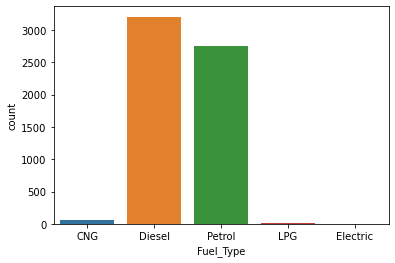

In [13]:
#4   Fuel_Type
sns.countplot(cars.Fuel_Type)

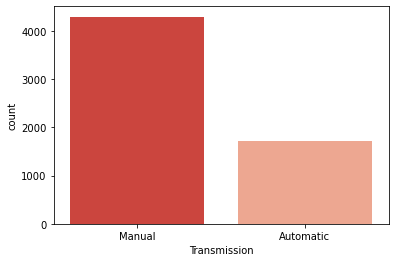

In [14]:
#5   Transmission
sns.countplot(cars.Transmission, palette="Reds_r")

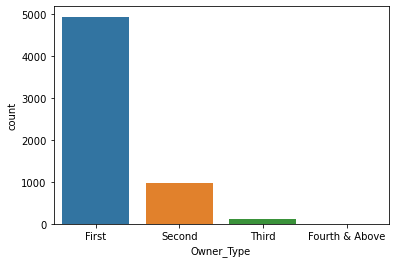

In [15]:
#6   Owner_Type
sns.countplot(cars.Owner_Type, order=['First','Second','Third','Fourth & Above'])

In [16]:
#7   Mileage
print("Null values:", cars.Mileage.isnull().sum())
print("Outliers:",(cars.Mileage==0).sum())

Null values: 2
Outliers: 0


*The null values in `Mileage` is because `Fuel_Type` is `Electric`.*

In [17]:
#Removing units and extracting numerical data from mileage
cars.Mileage = cars.Mileage.str.split(expand=True)[0].astype("float64")

In [18]:
#set the outliers as null
cars[cars.Mileage==0].Mileage = np.nan

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


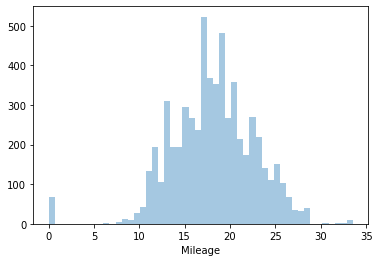

In [19]:
sns.distplot(cars.Mileage, kde=False)

In [20]:
#7   Engine
print("Total null values:",cars.Engine.isnull().sum())
cars[cars.Engine.isnull()].head()

Total null values: 36


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
194,Honda City 1.5 GXI,Ahmedabad,2007,60006.0,Petrol,Manual,First,0.0,NaN,NaN,NaN,NaN,2.95
208,Maruti Swift 1.3 VXi,Kolkata,2010,42001.0,Petrol,Manual,First,16.1,NaN,NaN,NaN,NaN,2.11
733,Maruti Swift 1.3 VXi,Chennai,2006,97800.0,Petrol,Manual,Third,16.1,NaN,NaN,NaN,NaN,1.75
749,Land Rover Range Rover 3.0 D,Mumbai,2008,55001.0,Diesel,Automatic,Second,0.0,NaN,NaN,NaN,NaN,26.50
1294,Honda City 1.3 DX,Delhi,2009,55005.0,Petrol,Manual,First,12.8,NaN,NaN,NaN,NaN,3.20


In [21]:
#Removing units and extracting numerical data from Engine
cars.Engine = cars.Engine.str.split(expand=True)[0].astype("float64")

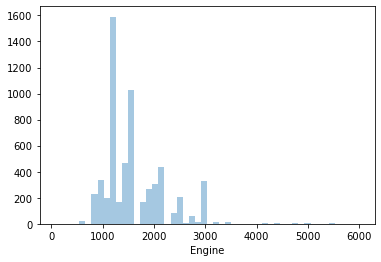

In [22]:
sns.distplot(cars.Engine, kde=False)

In [23]:
#8 Power
print("Total null values:",cars.Power.isnull().sum())
cars[cars.Power.isnull()].head()

Total null values: 36


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
194,Honda City 1.5 GXI,Ahmedabad,2007,60006.0,Petrol,Manual,First,0.0,NaN,NaN,NaN,NaN,2.95
208,Maruti Swift 1.3 VXi,Kolkata,2010,42001.0,Petrol,Manual,First,16.1,NaN,NaN,NaN,NaN,2.11
733,Maruti Swift 1.3 VXi,Chennai,2006,97800.0,Petrol,Manual,Third,16.1,NaN,NaN,NaN,NaN,1.75
749,Land Rover Range Rover 3.0 D,Mumbai,2008,55001.0,Diesel,Automatic,Second,0.0,NaN,NaN,NaN,NaN,26.50
1294,Honda City 1.3 DX,Delhi,2009,55005.0,Petrol,Manual,First,12.8,NaN,NaN,NaN,NaN,3.20


In [24]:
#Removing units and extracting numerical data from Power
cars.Power = cars.Power.apply(lambda s: np.nan if "null" in str(s) else s).str.split(expand=True)[0].astype("float64")

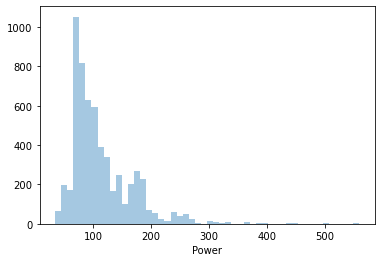

In [25]:
sns.distplot(cars.Power, kde=False)

In [26]:
#9 Seats
print("Total null values:",cars.Seats.isnull().sum())
cars[cars.Seats.isnull()].head()

Total null values: 42


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
194,Honda City 1.5 GXI,Ahmedabad,2007,60006.0,Petrol,Manual,First,0.0,NaN,NaN,NaN,NaN,2.95
208,Maruti Swift 1.3 VXi,Kolkata,2010,42001.0,Petrol,Manual,First,16.1,NaN,NaN,NaN,NaN,2.11
229,Ford Figo Diesel,Bangalore,2015,70436.0,Diesel,Manual,First,0.0,1498.0,99.0,NaN,NaN,3.60
733,Maruti Swift 1.3 VXi,Chennai,2006,97800.0,Petrol,Manual,Third,16.1,NaN,NaN,NaN,NaN,1.75
749,Land Rover Range Rover 3.0 D,Mumbai,2008,55001.0,Diesel,Automatic,Second,0.0,NaN,NaN,NaN,NaN,26.50


In [27]:
cars.loc[cars.Seats<1,"Seats"] = np.nan

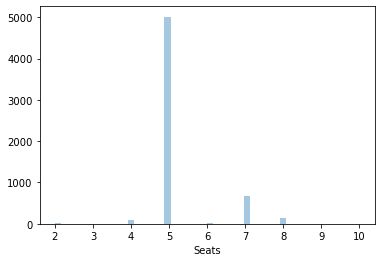

In [28]:
sns.distplot(cars.Seats, kde=False)

*Note: We will impute Engine, Power and seats based on Brand(extract brand during feature engineering).*

In [29]:
#10 New_Price
print("Total null values:",cars.New_Price.isnull().sum())
cars[cars.New_Price.isnull()].head()

Total null values: 5195


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000.0,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000.0,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,12.50
3,Maruti Ertiga VDI,Chennai,2012,87000.0,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670.0,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,17.74
5,Hyundai EON LPG Era Plus Option,Hyderabad,2012,75000.0,LPG,Manual,First,21.10,814.0,55.20,5.0,NaN,2.35


In [30]:
cars.New_Price = cars.New_Price.apply(lambda s: float(s.split()[0])*100 if "Cr" in str(s) else str(s).split()[0]).astype("float64")

Total null values: 5195


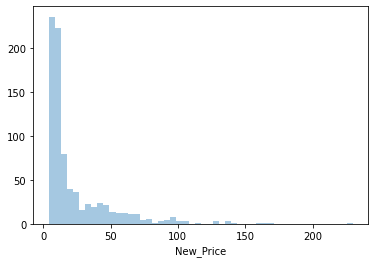

In [31]:
print("Total null values:",cars.New_Price.isnull().sum())
sns.distplot(cars.New_Price, kde=False)

In [32]:
#sns.pairplot(cars)

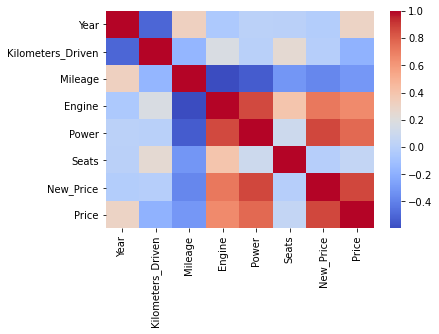

In [33]:
sns.heatmap(cars.corr(), cmap="coolwarm")

***Some Feature Engineering and Preprocessing***

***Extracting brand and model names from name***

In [34]:
carnames = cars.Name.str.split(expand=True)[[0,1,2]]

In [35]:
carnames.rename(columns={0:'Brand',1:'Model',2:'Type'}, inplace=True)

In [36]:
cars = cars.join(carnames)
cars = cars.drop("Name", axis=1)

***Creating new features using combinations of categorical columns***

In [37]:
from itertools import combinations

object_cols = cars.select_dtypes("object").columns
low_cardinality_cols = [col for col in object_cols if cars[col].nunique() < 15]
low_cardinality_cols.append("Brand")
interactions = pd.DataFrame(index=cars.index)

# Iterate through each pair of features, combine them into interaction features
for features in combinations(low_cardinality_cols,2):
    
    new_interaction = cars[features[0]].map(str)+"_"+cars[features[1]].map(str)
    
    encoder = LabelEncoder()
    interactions["_".join(features)] = encoder.fit_transform(new_interaction)

In [38]:
cars = cars.join(interactions) #append to the dataset

In [39]:
cars.head(5)

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,...,Location_Fuel_Type,Location_Transmission,Location_Owner_Type,Location_Brand,Fuel_Type_Transmission,Fuel_Type_Owner_Type,Fuel_Type_Brand,Transmission_Owner_Type,Transmission_Brand,Owner_Type_Brand
0,Mumbai,2010,72000.0,CNG,Manual,First,26.60,998.0,58.16,5.0,...,26,19,28,217,0,0,1,4,38,16
1,Pune,2015,41000.0,Diesel,Manual,First,19.67,1582.0,126.20,5.0,...,32,21,32,236,2,3,12,4,33,9
2,Chennai,2011,46000.0,Petrol,Manual,First,18.20,1199.0,88.70,5.0,...,8,5,6,48,6,10,43,4,32,8
3,Chennai,2012,87000.0,Diesel,Manual,First,20.77,1248.0,88.76,7.0,...,6,5,6,53,2,3,19,4,38,16
4,Coimbatore,2013,40670.0,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,...,9,6,12,64,1,5,5,2,0,32


In [40]:
# cars.info()

*Now, we need to impute the missing values*

*And before that we need to do train test split to prevent data leakage*

In [41]:
features = cars.drop(["Price"], axis=1)
target = cars["Price"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=0)

*Now, let's see those missing values*

In [42]:
X_train.isnull().sum()

Location                      0
Year                          0
Kilometers_Driven             6
Fuel_Type                     0
Transmission                  0
Owner_Type                    0
Mileage                       1
Engine                       25
Power                       107
Seats                        31
New_Price                  3887
Brand                         0
Model                         0
Type                          0
Location_Fuel_Type            0
Location_Transmission         0
Location_Owner_Type           0
Location_Brand                0
Fuel_Type_Transmission        0
Fuel_Type_Owner_Type          0
Fuel_Type_Brand               0
Transmission_Owner_Type       0
Transmission_Brand            0
Owner_Type_Brand              0
dtype: int64

*We need to fill missing values in Engine, Power and Seats only. Missing values in Subtype and Subtype_2 would provide a feature.*

*Note: XGBoost and Light GBM have an inbuilt feature to handle missing values. So, we can also leave missing values as it is.*

*Let's fill missing values based on brand column.*


In [43]:
num_cols = X_train.drop('New_Price',1).select_dtypes("number")
null_num_cols = num_cols.columns[num_cols.isnull().any()]

for cols in null_num_cols:
    X_train.loc[:,cols] = X_train.loc[:,cols].fillna(X_train.groupby('Brand')[cols].transform('mean'))
    X_train.loc[:,cols] = X_train.loc[:,cols].fillna(X_train[cols].mean())

    X_test.loc[:,cols] = X_test.loc[:,cols].fillna(X_test.groupby('Brand')[cols].transform('mean'))
    X_test.loc[:,cols] = X_test.loc[:,cols].fillna(X_test[cols].mean())

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [44]:
# #Binning #didn't provide improvement to results
# #Year
# X_train=X_train.drop('Year',1).join(pd.cut(X_train.Year, range(1996,2021,4), False, range(6)).astype('int64'))
# X_test=X_test.drop('Year',1).join(pd.cut(X_test.Year, range(1996,2021,4), False, range(6)).astype('int64'))

# #Kilometers_Driven
# X_train=X_train.drop('Kilometers_Driven',1).join(pd.cut(X_train.Kilometers_Driven, range(0,300001,10000), labels= range(30)).astype('int64'))
# X_test=X_test.drop('Kilometers_Driven',1).join(pd.cut(X_test.Kilometers_Driven, range(0,300001,10000), labels= range(30)).astype('int64'))

In [45]:
cars.select_dtypes("object").nunique()

Location         11
Fuel_Type         5
Transmission      2
Owner_Type        4
Brand            31
Model           212
Type            339
dtype: int64

### Encoding the categorical columns

*One-hot encoding*

In [46]:
OHE_cat_features = ["Fuel_Type","Transmission", "Location", "Owner_Type", "Brand"]
OH_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[OHE_cat_features]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[OHE_cat_features]))

OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

OH_cols_train.columns = OH_encoder.get_feature_names(OHE_cat_features)
OH_cols_test.columns = OH_encoder.get_feature_names(OHE_cat_features)

X_train_enc = X_train.join(OH_cols_train)
X_test_enc = X_test.join(OH_cols_test)

*Drop OHE encoded columns*

In [47]:
X_train_enc.drop(OHE_cat_features, axis=1, inplace = True)
X_test_enc.drop(OHE_cat_features, axis=1, inplace = True)

*Target encoding*

In [48]:
target_cat_features = X_train_enc.select_dtypes('object').columns
target_enc = ce.TargetEncoder(cols=target_cat_features)
target_enc.fit(X_train[target_cat_features], y_train)
X_train_enc = X_train_enc.join(target_enc.transform(X_train[target_cat_features]).add_suffix('_enc'))
X_test_enc = X_test_enc.join(target_enc.transform(X_test[target_cat_features]).add_suffix('_enc'))

*Drop categorical columns(dtype: object)*

In [49]:
object_cols = X_train_enc.select_dtypes('object')
X_train_enc.drop(object_cols, axis=1, inplace = True)
X_test_enc.drop(object_cols, axis=1, inplace = True)

*Conversion of all columns into int64*

In [50]:
# X_train_enc=X_train_enc.astype('int64')
# X_test_enc=X_test_enc.astype('int64')

In [51]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4514 entries, 1329 to 2732
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       4514 non-null   int64  
 1   Kilometers_Driven          4514 non-null   float64
 2   Mileage                    4514 non-null   float64
 3   Engine                     4514 non-null   float64
 4   Power                      4514 non-null   float64
 5   Seats                      4514 non-null   float64
 6   New_Price                  627 non-null    float64
 7   Location_Fuel_Type         4514 non-null   int64  
 8   Location_Transmission      4514 non-null   int64  
 9   Location_Owner_Type        4514 non-null   int64  
 10  Location_Brand             4514 non-null   int64  
 11  Fuel_Type_Transmission     4514 non-null   int64  
 12  Fuel_Type_Owner_Type       4514 non-null   int64  
 13  Fuel_Type_Brand            4514 non-null   in

***Feature selection based on pearson correlation***

In [52]:
pcorr = X_train_enc.join(y_train).corr()
imp_corr_cols = pcorr[['Price']][pcorr['Price']>-0.25].iloc[:-1].index

X_train_enc = X_train_enc[imp_corr_cols]
X_test_enc = X_test_enc[imp_corr_cols]

In [53]:
from xgboost import XGBRegressor

***XGB model***

In [54]:
base_xgbr = XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist')
base_xgbr.fit(X_train_enc,y_train)

base_xgbr.score(X_test_enc,y_test) #r2 score

0.9078910231835914

*Visualizing the test results*

3.3929730043857638


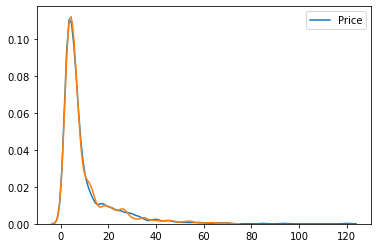

In [55]:
yhat_xgbr = base_xgbr.predict(X_test_enc)
print(mean_squared_error(y_test, yhat_xgbr, squared=False))
sns.kdeplot(y_test)
sns.kdeplot(yhat_xgbr)

*Feature importance based on the XGBoost model*

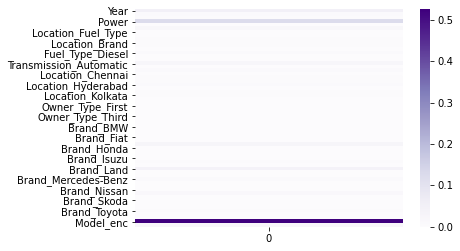

In [56]:
feat_imp = pd.DataFrame(base_xgbr.feature_importances_, index=X_train_enc.columns)
sns.heatmap(feat_imp, cmap='Purples')

***Feature selection based on XGBoost model***

In [57]:
impfeat = pd.Series(base_xgbr.feature_importances_, index=X_train_enc.columns)
impcols = impfeat[impfeat>0.005].index
X_train_enc = X_train_enc[impcols]
X_test_enc = X_test_enc[impcols]

*Visualizing pearson correlation of finally selected columns*

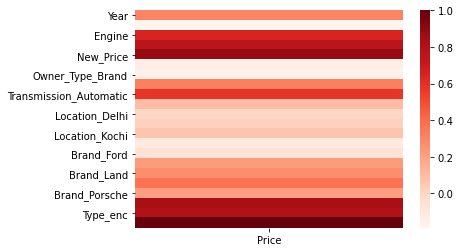

In [58]:
sns.heatmap(X_train_enc.join(y_train).corr()[['Price']], cmap='Reds')

In [59]:
#testing xgbr model
# param_grid = {
#     "learning_rate": [0.05],
#     "max_depth": [6,8,10,12],
#     "min_child_weight": [5],
#     "n_estimators": [350,400,450,500],
#     "subsample": [0.55]
# }
# gscv = GridSearchCV(estimator=base_xgbr, param_grid=param_grid, n_jobs=-1, verbose=5, cv=4)

In [60]:
# gscv.fit(X_train_enc, y_train)

In [61]:
#the best params from the given parameter grid
# gscv.best_params_
# gscv.score(X_test_enc,y_test) #r2 score

In [62]:
# tuned_xgbr = XGBRegressor(objective = 'reg:squarederror',
#                     learning_rate = 0.05, max_depth = 12, min_child_weight = 5,
#                     n_estimators = 500, subsample = 0.55)
# tuned_xgbr.fit(X_train_enc,y_train)

# tuned_xgbr.score(X_test_enc,y_test) #r2 score

In [63]:
# yhat_xgbr = tuned_xgbr.predict(X_test_enc)
# print(mean_squared_error(y_test, yhat_xgbr, squared=False))
# sns.kdeplot(y_test)
# sns.kdeplot(yhat_xgbr)

### Base LGBM model

In [64]:
from lightgbm import LGBMRegressor

In [65]:
base_lgbmr = LGBMRegressor()

In [66]:
base_lgbmr.fit(X_train_enc, y_train)
base_lgbmr.score(X_test_enc,y_test)

0.910630872126766

3.342128817765491


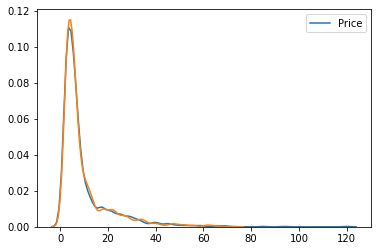

In [67]:
yhat_lgbmr = base_lgbmr.predict(X_test_enc)
print(mean_squared_error(y_test, yhat_lgbmr, squared=False))
sns.kdeplot(y_test)
sns.kdeplot(yhat_lgbmr)

In [68]:
#feature importance
#pd.Series(base_lgbmr.feature_importances_, index=X_train_enc.columns)

In [69]:
base_lgbmr.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [70]:
#initial grid search
param_grid = {
    "learning_rate": [0.15],
    "max_depth": [5,8,10,12],
    "min_child_weight": [3,5,6,8],
    "n_estimators": [300,500,800,1000,1200],
    "num_leaves": [20,25,40,50],
    "subsample": [0.3,0.5]
}
# gscv_lgbm = GridSearchCV(estimator=base_lgbmr, param_grid=param_grid, n_jobs=-1, verbose=5, cv=4)

In [71]:
# gscv_lgbm.fit(X_train_enc, y_train)

In [72]:
# gscv_lgbm.best_params_

In [73]:
# gscv_lgbm.score(X_test_enc,y_test) #r2 score

In [74]:
param_grid2 = {
    "learning_rate": [0.15],
    "max_depth": [8],
    "n_estimators": [1500,1800],
    "num_leaves": [25,27],
    'reg_alpha': [0,0.001,0.01],
    'reg_lambda': [0,0.001,0.01]
}
gscv_lgbm2 = GridSearchCV(estimator=base_lgbmr, param_grid=param_grid2, n_jobs=-1, verbose=5, cv=4)

In [75]:
gscv_lgbm2.fit(X_train_enc, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  4.0min finished


GridSearchCV(cv=4, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.15], 'max_depth': [8],
                         'n_estimators': [1500, 1800], 'num_leaves': [25, 27],
                         'reg_alpha': [0, 0.001, 0.01],
                         'reg_lambda': [0, 0.001, 0.01]},
             verbose=5)

In [76]:
print(gscv_lgbm2.best_params_)
print(gscv_lgbm2.score(X_test_enc,y_test)) #r2 score

{'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 1500, 'num_leaves': 25, 'reg_alpha': 0.001, 'reg_lambda': 0.01}
0.9324189085159978


### Tuned LGBM model

In [77]:
tuned_lgbmr = LGBMRegressor(**gscv_lgbm2.best_params_)
tuned_lgbmr.fit(X_train_enc, y_train)
tuned_lgbmr.score(X_test_enc,y_test)

0.9324189085159978

2.906310601448042


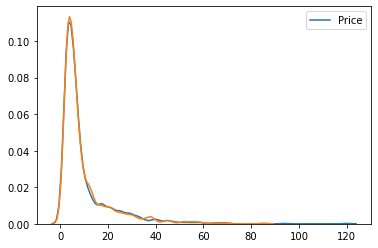

In [78]:
yhat_lgbmr = tuned_lgbmr.predict(X_test_enc)
print(mean_squared_error(y_test, yhat_lgbmr, squared=False))
sns.kdeplot(y_test)
sns.kdeplot(yhat_lgbmr)

*The Tuned LGBM Regressor model will be used as the final model for our predictions*

In [79]:
# Custom Label Encoder for handling unknown values
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)


***Let's preprocess our original training data.***

In [80]:
X_train = cars_Train.drop('Price',1)
y_train = cars.Price
X_test = cars_Test

*Let's apply the feature engineering and preprocessing to the training and testing data*

In [81]:
carnames = X_train.Name.str.split(expand=True)[[0,1,2]]
carnames_test = X_test.Name.str.split(expand=True)[[0,1,2]]

carnames.rename(columns={0:'Brand',1:'Model',2:'type'}, inplace=True)
carnames_test.rename(columns={0:'Brand',1:'Model',2:'type'}, inplace=True)

X_train = X_train.join(carnames)
X_train = X_train.drop("Name", axis=1)
X_test = X_test.join(carnames_test)
X_test = X_test.drop("Name", axis=1)

In [82]:
object_cols = X_train.select_dtypes("object").columns
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 15]
low_cardinality_cols.append("Brand")
interactions = pd.DataFrame(index=X_train.index)
interactions_test = pd.DataFrame(index=X_test.index)

for features in combinations(low_cardinality_cols,2):
    
    new_interaction = X_train[features[0]].map(str)+"_"+X_train[features[1]].map(str)
    new_interaction_test = X_test[features[0]].map(str)+"_"+X_test[features[1]].map(str)
    
    encoder = LabelEncoderExt()
    encoder.fit(new_interaction)
    interactions["_".join(features)] = encoder.transform(new_interaction)
    interactions_test["_".join(features)] = encoder.transform(new_interaction_test)

In [83]:
X_train = X_train.join(interactions)
X_test = X_test.join(interactions_test)

In [84]:
num_cols = X_train.drop('New_Price',1).select_dtypes("number")
null_num_cols = num_cols.columns[num_cols.isnull().any()]

for cols in null_num_cols:
    X_train.loc[:,cols] = X_train.loc[:,cols].fillna(X_train.groupby('Brand')[cols].transform('mean'))
    X_train.loc[:,cols] = X_train.loc[:,cols].fillna(X_train[cols].mean())

    X_test.loc[:,cols] = X_test.loc[:,cols].fillna(X_test.groupby('Brand')[cols].transform('mean'))
    X_test.loc[:,cols] = X_test.loc[:,cols].fillna(X_test[cols].mean())

In [85]:
num_cols = X_train.select_dtypes("number")
null_num_cols = num_cols.columns[num_cols.isnull().any()]

for cols in null_num_cols:
    X_train.loc[:,cols] = X_train.loc[:,cols].fillna(X_train.groupby('Brand')[cols].transform('mean'))
    X_train.loc[:,cols] = X_train.loc[:,cols].fillna(X_train[cols].mean())

    X_test.loc[:,cols] = X_test.loc[:,cols].fillna(X_test.groupby('Brand')[cols].transform('mean'))
    X_test.loc[:,cols] = X_test.loc[:,cols].fillna(X_test[cols].mean())

In [86]:
OHE_cat_features = ["Fuel_Type","Transmission", "Location", "Owner_Type", "Brand"]
OH_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[OHE_cat_features]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[OHE_cat_features]))

OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

OH_cols_train.columns = OH_encoder.get_feature_names(OHE_cat_features)
OH_cols_test.columns = OH_encoder.get_feature_names(OHE_cat_features)

X_train_enc = X_train.join(OH_cols_train)
X_test_enc = X_test.join(OH_cols_test)

In [87]:
X_train_enc.drop(OHE_cat_features, axis=1, inplace = True)
X_test_enc.drop(OHE_cat_features, axis=1, inplace = True)

In [88]:
target_cat_features = X_train_enc.select_dtypes('object').columns
target_enc = ce.TargetEncoder(cols=target_cat_features)
target_enc.fit(X_train[target_cat_features], y_train)
X_train_enc = X_train_enc.join(target_enc.transform(X_train[target_cat_features]).add_suffix('_enc'))
X_test_enc = X_test_enc.join(target_enc.transform(X_test[target_cat_features]).add_suffix('_enc'))

In [89]:
object_cols = X_train_enc.select_dtypes('object')
X_train_enc.drop(object_cols, axis=1, inplace = True)
X_test_enc.drop(object_cols, axis=1, inplace = True)

In [90]:
pcorr = X_train_enc.join(y_train).corr()
imp_corr_cols = pcorr[['Price']][pcorr['Price']>-0.25].iloc[:-1].index

X_train_enc = X_train_enc[imp_corr_cols]
X_test_enc = X_test_enc[imp_corr_cols]

In [91]:
xgbr = XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist')
xgbr.fit(X_train_enc,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [92]:
impfeat = pd.Series(xgbr.feature_importances_, index=X_train_enc.columns)
impcols = impfeat[impfeat>0.005].index
X_train_enc = X_train_enc[impcols]
X_test_enc = X_test_enc[impcols]

*Model Training*

In [93]:
lgbmr = LGBMRegressor(**gscv_lgbm2.best_params_)

lgbmr.fit(X_train_enc, y_train)

LGBMRegressor(learning_rate=0.15, max_depth=8, n_estimators=1500, num_leaves=25,
              reg_alpha=0.001, reg_lambda=0.01)

***Let's predict***

In [94]:
preds_test = lgbmr.predict(X_test_enc)

In [95]:
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)